# Connecting to the HPC

Connect first to VPN.

```ssh md1xmtsx@stanage.shef.ac.uk```
(need password)

to connect to a node,
```srun --pty bash -i``` 

## Create slurm batch script

## Use slurm

```sbatch --array=0-30 submission_paper_xval.sh```

In [38]:
batchscript = r"""#!/bin/bash
#SBATCH --mem=120G
#SBATCH --time=4-00:00:00
#SBATCH --cpus-per-task=20
#SBATCH --array=1-2
/users/md1xmtsx/anaconda3/bin/python /users/md1xmtsx/script.py --outputname resultRun12big --rep=$SLURM_ARRAY_TASK_ID --features=12000 --particles=60 --ls=5 --k0task=16.02 --resT 250
"""

In [39]:
script = r"""import pickle
from advectionGPdatasets.roundhill import RoundHill,RoundHillModel
from advectionGP.kernels import EQ
from advectionGP.kernels import meshgridndim
from advectionGP.constraints import NonNegConstraint
import numpy as np
import matplotlib.pyplot as plt
import argparse
parser = argparse.ArgumentParser(description='Run roundhill pollution model')
parser.add_argument("--outputname", help="First part of output filename", type=str)
parser.add_argument("--rep", help="Starting with this random seed", type=int)
parser.add_argument("--features", help="Number of features", type=int)
parser.add_argument("--particles", help="Number of particles per observation", type=int)
parser.add_argument("--ls", help="Lengthscale", type=float)
#parser.add_argument("--k0", help="k0", type=float)
parser.add_argument("--k0task", help="k0task", type=float)
parser.add_argument("--resT", help="resolution (in time)", type=int)
parser.add_argument('--ground', default=False, action='store_true', help='include reflecting ground plane')
#parser.add_argument('--nnconstraint', default=False, action='store_true', help='set a portion of the domain to be non-negative')
#parser.add_argument('--nnconstraint', default=0, help='set a portion of the domain to be non-negative (0 or 1)', type=int)
args = parser.parse_args()
rep = args.rep
np.random.seed(rep)
Nfeat = args.features
Npart = args.particles
res = [args.resT,100,100,10]
ls = args.ls
s2 = 1000
fnstart = args.outputname
nnconstraint = bool(rep%2) #even = no constraint, odd=constraint #bool(args.nnconstraint)
#k0 = args.k0 #0.2 #0.5

k0 = 10**((args.k0task-20)/10.0)
print("k0 set to %0.5f" % k0)
if args.ground:
    walls = [(3,0,-1)]
else:
    walls = None

def getfn(fnstart,nnconstraint,walls,s2,ls,k0,Nfeat,Npart,rep):
    fn = '%s_%s%s_s2=%d_ls=%d_k0=%0.3f_Nfeat=%d_Nparticles=%d_rep=%d.pkl' % (fnstart,'nncon' if nnconstraint else '','wall' if walls is not None else '',s2,ls,k0,Nfeat,Npart,rep)
    return fn

fn = getfn(fnstart,nnconstraint,walls,s2,ls,k0,Nfeat,Npart,rep)
print(fn)
try:
    pickle.load(open(fn,'rb'))
except:
    k = EQ(np.array([400,ls,ls,ls]), s2)
    print("Building and computing standard roundhill model")
    rhm = RoundHillModel(N_feat=Nfeat,Nparticles=Npart,k=k,res=res,k_0=k0,holdout=True,walls=walls)
    rhm.compute(30,scaleby=[args.resT//10,1,1,1])

    if nnconstraint:
        print("Starting Non-negative constraint sampling")
        top,bottom = np.array([-60., -70.,  -30., 0.]), np.array([200.,  68, 60, 30.])
        Xnonneg = meshgridndim([top,bottom],np.array([6,20,20,8]),True) #Run8...
        #Xnonneg = meshgridndim([top,bottom],np.array([6,25,25,8]),True) #Run9...
        #nnc = NonNegConstraint(rhm.mInfer,rhm.Y,Xnonneg,thinning=5000,jitter=1e-4,verbose=True,burnin=50,usecaching=False)#,startpointnormalised=True)
        nnc = NonNegConstraint(rhm.mInfer,rhm.Y,Xnonneg,thinning=500,jitter=1e-4,verbose=True,burnin=1000)#,usecaching=True)#,startpointnormalised=True)
        samps = nnc.sample(30)
        print("Computing posterior for samples...")
        rhm.compute(1,Zs=samps,scaleby=[args.resT//10,1,1,1])

    #make file smaller (can't store all of mInfer, which is part of rhm)
    gridstepsize = rhm.mInfer.getGridStepSize()[0]
    boundary = rhm.mInfer.boundary
    Ytest = rhm.Ytest[rhm.Xtest[:,1]>=0]
    print("Saving to %s" % (fn))
    #rhm.results['conc']['all']=None #erase to save space
    #rhm.results['sources']['all']=None #erase to save space
    pickle.dump({'results':rhm.results,'gridstepsize':gridstepsize,'boundary':boundary,'rmse':rhm.compute_RMSE(),'Ytest':Ytest},open(fn,'wb'))

"""

In [40]:
with open("script.py","w+") as f:
    f.writelines(script)

with open("batchscript.sh","w+") as f:
    f.writelines(batchscript)

In [22]:
#run
#!scp script.py batchscript.sh md1xmtsx@stanage.shef.ac.uk:/users/md1xmtsx

In [47]:
#Run: ssh md1xmtsx@stanage.shef.ac.uk
#on the server run:
#sbatch batchscript.sh
#
#to see how it's going:
#squeue --user=md1xmtsx
#
#or cat the slurm-012345435.out
#
#locally:
#!mkdir hpcdata

In [1]:
#run
#!scp md1xmtsx@stanage.shef.ac.uk:/users/md1xmtsx/resultRun12big* hpcdata

In [1]:
#Useful to get access to mInfer for grid coordinate calculations
from advectionGPdatasets.roundhill import RoundHill,RoundHillModel
from advectionGP.kernels import EQ
from advectionGP.kernels import meshgridndim
import numpy as np
import matplotlib.pyplot as plt
 #--outputname resultRun12big --rep=$SLURM_ARRAY_TASK_ID --features=12000 --particles=60 --ls=5 --k0task=16.02 --resT 250
#resultRun12big_nncon_s2=1000_ls=5_k0=0.400_Nfeat=12000_Nparticles=60
rhm = RoundHillModel(N_feat=12,Nparticles=1,res=[250,100,100,10],k_0=16.02)

sourcegridpos = rhm.mInfer.getGridCoord([0,0,0,0],floorResult=False)[[1,2]]
xtickvals = np.arange(np.trunc(rhm.mInfer.boundary[0][1]/50)*50,rhm.mInfer.boundary[1][1],50)+0
ytickvals = np.arange(np.trunc(rhm.mInfer.boundary[0][2]/50)*50,rhm.mInfer.boundary[1][2],50)+0
temp = np.zeros([len(xtickvals),4])
temp[:,1] = xtickvals
xtickpos = rhm.mInfer.getGridCoord(temp)[:,1]

temp = np.zeros([len(ytickvals),4])
temp[:,2] = ytickvals
ytickpos = rhm.mInfer.getGridCoord(temp)[:,2]

yslicerealpos = 33
temp = np.array([[0,0,yslicerealpos,0]])
yslicepos = rhm.mInfer.getGridCoord(temp)[0,2]

/home/mike/anaconda3/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/mike/anaconda3/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/mike/anaconda3/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor
/home/mike/anaconda3/lib/python3.12/site-packages/matplotlib/collections.py:996: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


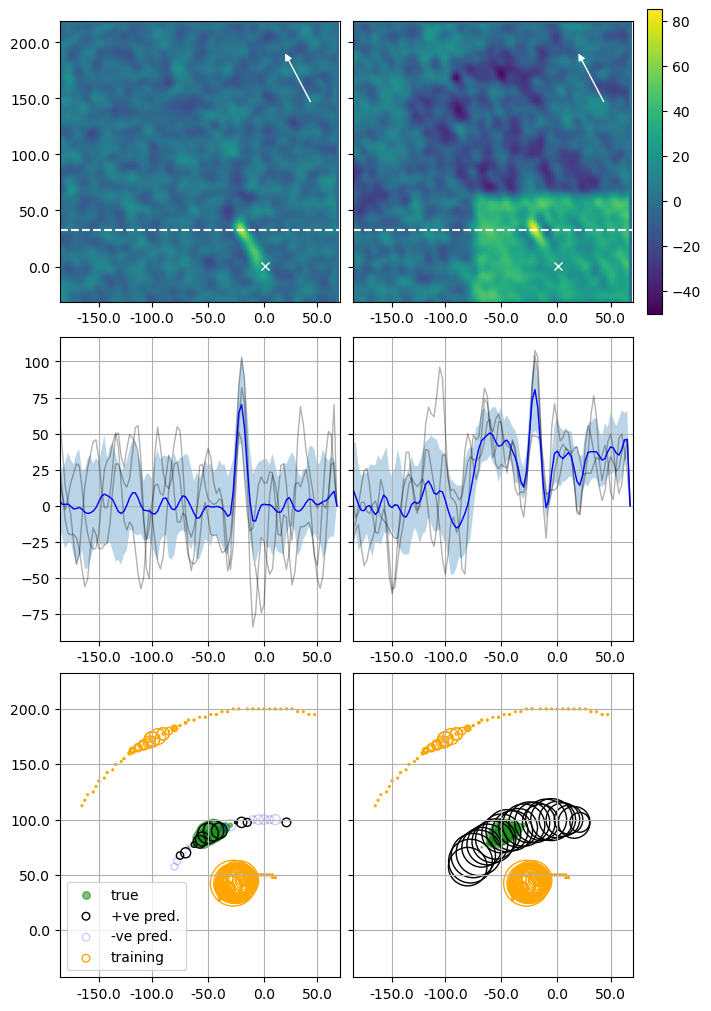

In [2]:
import pickle
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
fig, axs = plt.subplots(3,2, figsize=(7,10), sharey='row', layout='constrained')
#normal; non-negative
datafiles = ['hpcdata/resultRun12bigB__s2=1000_ls=5_k0=0.400_Nfeat=12000_Nparticles=60_rep=2.pkl','hpcdata/resultRun12big_nncon_s2=1000_ls=5_k0=0.400_Nfeat=12000_Nparticles=60_rep=1.pkl']
for i,datafile in enumerate(datafiles):
    dataset = pickle.load(open(datafile,'rb'))
    #break
    ax = axs[0,i]
    plotdata = np.mean(np.mean(dataset['results']['sources']['all'],0)[:1,:,:,0],0)
    im = ax.imshow(plotdata.T,origin='lower',clim=[-50,85])
    if i == 1: fig.colorbar(im)    
    ax.plot(sourcegridpos[0],sourcegridpos[1],'wx')
    ax.set_xticks(xtickpos,xtickvals);
    ax.set_yticks(ytickpos,ytickvals);
    windvect = rhm.mInfer.windmodel.getwind(np.array([[0,0,0,0]]))[0,0:2]
    ax.plot([0,100],[yslicepos,yslicepos],'w--')
    #wind direction same in grid coords as axes are equally spaced
    #temp = np.zeros([1,4])
    #temp[0,1:4] = windvect[0,:]
    #temp = rhm.mInfer.getGridCoord(temp)[:,2]
    vA = np.array([90,70])
    vB = vA + windvect*10
    ax.annotate("", xytext=vA, xy=vB,arrowprops=dict(arrowstyle="-|>",fill=True,facecolor='white',edgecolor='white'))
    ax.set_xbound(0,100)
#fig, axs = plt.subplots(2,2, figsize=(6.5,6.5),layout='constrained')
#datafiles = ['hpcdata/resultRun12big__s2=1000_ls=5_k0=0.400_Nfeat=12000_Nparticles=60_rep=2.pkl','hpcdata/resultRun12big_nncon_s2=1000_ls=5_k0=0.400_Nfeat=12000_Nparticles=60_rep=1.pkl']
for i,datafile in enumerate(datafiles):   
    dataset = pickle.load(open(datafile,'rb'))
    plotdata = dataset['results']['sources']['all'][:,1,:,yslicepos,0]
    ax = axs[1,i]
    ax.plot(plotdata.T[:,:3],'k-',alpha=0.3,linewidth=1)
    ax.plot(dataset['results']['sources']['mean'][1,:,yslicepos,0],'b-',linewidth=1)
    #try:
        #34% --> 30×(0.5−0.34) = 5 or 25
    ax.fill_between(np.arange(100),np.sort(plotdata.T)[:,5],np.sort(plotdata.T)[:,-5],alpha=0.3)
    #except:
    #    pass
    #ax.plot(np.sort(plotdata.T)[:,1],'g-')
    #ax.plot(np.arange(30),np.sort(plotdata.T)[:,1])#,np.sort(plotdata.T)[:,-2])
    #plt.plot(sourcegridpos[0],sourcegridpos[1],'wx')
    ax.grid()
    ax.set_xticks(xtickpos,xtickvals);
    ax.set_xlim(0,100)
    ax.set_xbound(0,100)
    ax = axs[2,i]
    rhm.plot_test(ax=ax,preds = dataset['results']['testconc']['mean'],getGridCoordMethod=rhm.mInfer.getGridCoord,legend=i==0)
    ax.set_xticks(xtickpos,xtickvals);
    ax.set_yticks(ytickpos,ytickvals);
    ax.set_xbound(0,100)
    ax.set_ybound(-5,105)
    #ax.set_xlim(-5,105)
plt.savefig('demo.pdf')